# `map_of_racetracks_to_stations.ipynb`

### Author: Anthony Hein

#### Last updated: 11/23/2021

# Overview:

Overlap a network of racetracks to the stations from which they select weather data onto a map.

---

## Setup

In [2]:
from datetime import datetime
import git
import os
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `races_selected_trimmed_clean.csv`

In [4]:
races_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/races_selected_trimmed_clean.csv", low_memory=False) 
races_clean.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,station name,station lat,station lng,dist to station,station reading date,temp,msl,rain,rhum,station reading timedelta
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,BIRR,53.0525,-7.5325,45.288813,1/9/97 12:00,1.6,1012.4,0.0,87,15.0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,CASEMENT,53.1820,-6.2620,24.477602,2/16/97 15:00,8.0,992.5,0.4,87,20.0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,SHANNON AIRPORT,52.4125,-8.5505,63.534139,3/1/97 14:00,12.0,1003.5,0.0,73,0.0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,CASEMENT,53.1820,-6.2620,24.477602,4/24/97 14:00,12.6,1011.9,0.0,72,20.0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,SHANNON AIRPORT,52.4125,-8.5505,25.222137,5/8/97 17:00,11.1,994.2,0.0,59,30.0


In [5]:
races_clean.shape

(20201, 34)

---

## Map of Racetracks to Stations

In [6]:
races_raw = races_clean[['course', 'lat', 'lng', 'station name', 'station lat', 'station lng']]
races_raw

,course,lat,lng,station name,station lat,station lng
0,Thurles,52.688922,-7.836621,BIRR,53.0525,-7.5325
1,Punchestown,53.185820,-6.629293,CASEMENT,53.1820,-6.2620
2,Listowel,52.436912,-9.486635,SHANNON AIRPORT,52.4125,-8.5505
3,Punchestown,53.185820,-6.629293,CASEMENT,53.1820,-6.2620
4,Tipperary,52.499700,-8.206870,SHANNON AIRPORT,52.4125,-8.5505
...,...,...,...,...,...,...
20196,Down Royal,54.486962,-6.127716,CLONES,54.1100,-7.1400
20197,Clonmel,52.364895,-7.682520,KILKENNY,52.3955,-7.1610
20198,Leopardstown,53.266888,-6.195465,DUBLIN AIRPORT,53.2540,-6.1427
20199,Leopardstown,53.266888,-6.195465,DUBLIN AIRPORT,53.2540,-6.1427


In [7]:
races_raw = races_raw.drop_duplicates()
len(races_raw)

54

In [8]:
races_raw

,course,lat,lng,station name,station lat,station lng
0,Thurles,52.688922,-7.836621,BIRR,53.0525,-7.5325
1,Punchestown,53.185820,-6.629293,CASEMENT,53.1820,-6.2620
2,Listowel,52.436912,-9.486635,SHANNON AIRPORT,52.4125,-8.5505
4,Tipperary,52.499700,-8.206870,SHANNON AIRPORT,52.4125,-8.5505
5,Leopardstown,53.266888,-6.195465,DUBLIN AIRPORT,53.2540,-6.1427
7,Killarney,52.049008,-9.514649,SHANNON AIRPORT,52.4125,-8.5505
9,Clonmel,52.364895,-7.682520,KILKENNY,52.3955,-7.1610
10,Cork,52.132177,-8.685995,SHANNON AIRPORT,52.4125,-8.5505
11,Fairyhouse,53.484245,-6.467504,DUBLIN AIRPORT,53.2540,-6.1427
13,Curragh,53.167717,-6.839608,CASEMENT,53.1820,-6.2620


In [9]:
races_raw['course'].value_counts()

Navan           4
Galway          4
Kilbeggan       3
Sligo           3
Thurles         2
Punchestown     2
Bellewstown     2
Downpatrick     2
Tramore         2
Ballinrobe      2
Down Royal      2
Naas            2
Dundalk         2
Gowran Park     2
Wexford         2
Curragh         2
Fairyhouse      2
Clonmel         2
Killarney       2
Laytown         2
Limerick        1
Tralee          1
Cork            1
Roscommon       1
Leopardstown    1
Mallow          1
Tipperary       1
Listowel        1
Name: course, dtype: int64

In [10]:
races_raw.head()

,course,lat,lng,station name,station lat,station lng
0,Thurles,52.688922,-7.836621,BIRR,53.0525,-7.5325
1,Punchestown,53.185820,-6.629293,CASEMENT,53.1820,-6.2620
2,Listowel,52.436912,-9.486635,SHANNON AIRPORT,52.4125,-8.5505
4,Tipperary,52.499700,-8.206870,SHANNON AIRPORT,52.4125,-8.5505
5,Leopardstown,53.266888,-6.195465,DUBLIN AIRPORT,53.2540,-6.1427


In [11]:
import matplotlib.colors as mcolors

mcolors.TABLEAU_COLORS

OrderedDict([('tab:blue', '#1f77b4'),
             ('tab:orange', '#ff7f0e'),
             ('tab:green', '#2ca02c'),
             ('tab:red', '#d62728'),
             ('tab:purple', '#9467bd'),
             ('tab:brown', '#8c564b'),
             ('tab:pink', '#e377c2'),
             ('tab:gray', '#7f7f7f'),
             ('tab:olive', '#bcbd22'),
             ('tab:cyan', '#17becf')])

In [12]:
import random

random.seed(0)

courses = random.sample(list(np.unique(races_raw['course'])), 20)

In [13]:
spectrum = plt.get_cmap('tab20')
colors = spectrum(np.linspace(0, 1.0, len(courses)))
colors

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.68235294, 0.78039216, 0.90980392, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [1.        , 0.73333333, 0.47058824, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.59607843, 0.8745098 , 0.54117647, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [1.        , 0.59607843, 0.58823529, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.77254902, 0.69019608, 0.83529412, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.76862745, 0.61176471, 0.58039216, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.96862745, 0.71372549, 0.82352941, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.78039216, 0.78039216, 0.78039216, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.85882353, 0.85882353,

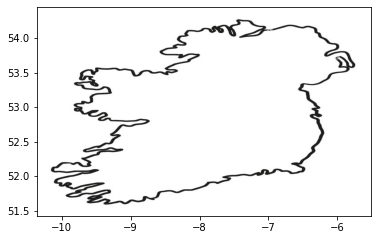

In [14]:
img = plt.imread(f"{BASE_DIR}/figures/ireland_map.png")
plt.imshow(img, extent=[-10.3634081, -5.507829899999998, 51.424112605, 54.453235295])

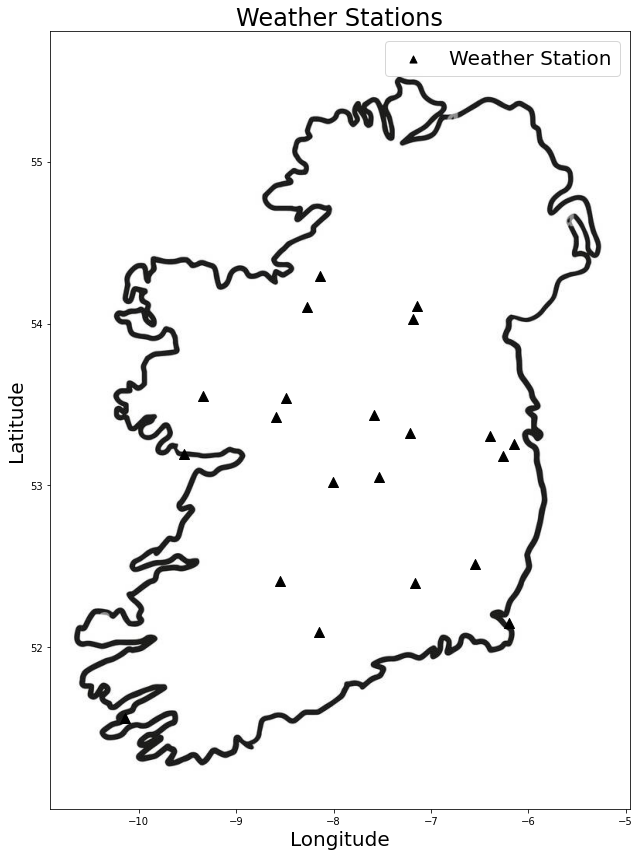

In [29]:
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Weather Stations", fontsize=24)

def transform_coords(lat, lng):
    """
    Due to the coordinates of the image.
    """

stations = races_raw[['station name', 'station lng', 'station lat']].groupby('station name').mean().reset_index()
for _, row in stations.iterrows():
    ax1.scatter(row['station lng'], row['station lat'], marker="^", s=100, color='black', zorder=10)
    
ax1.scatter(row['station lng'],
            row['station lat'],
            marker="^",
            s=50,
            color='black',
            zorder=10,
            label='Weather Station')

# for idx, course in enumerate(courses):
#     fst = True
#     color = colors[idx % len(colors)]
#     linestyle = linestyles[idx // len(colors)]
    
#     for _, row in races_raw[races_raw['course'] == course].iterrows():
#         xs = row['lng'], row['station lng']
#         ys = row['lat'], row['station lat']
#         ax1.plot(xs,
#                  ys,
#                  color=color,
#                  linestyle=linestyle,
#                  linewidth=2,
#                  marker="o",
#                  markersize=5,
#                  label=course if fst else None,
#                  zorder=2)
        
#         ax1.scatter(xs[0], ys[0], marker="o", s=50, color=color, zorder=2)
#         # ax1.annotate(course, (xs[0], ys[0]))
        
#         fst = False
        
ax1.set_xlabel("Longitude", fontsize=20)
ax1.set_ylabel("Latitude", fontsize=20)

xlims = ax1.get_xlim()
ylims = ax1.get_ylim()

plt.imshow(img,
           aspect='auto',
           extent=[
               -10.3634081 - 0.55,
               -5.507829899999998 + 0.55,
               51.424112605 - 0.42,
               54.453235295 + 1.35,
           ],
           zorder=1)

plt.legend(fontsize=20)

plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/map_of_weather_stations.png")

plt.show()

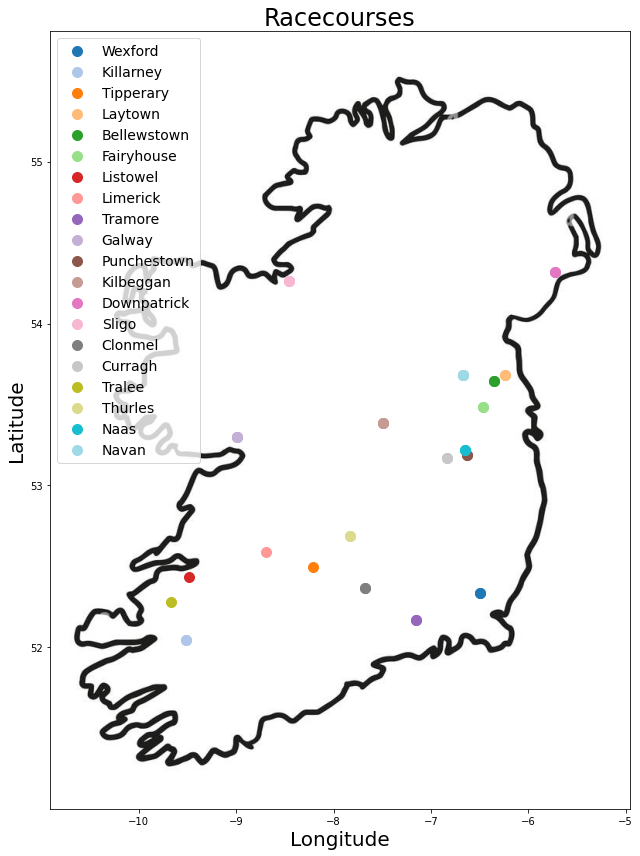

In [28]:
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Racecourses", fontsize=24)

def transform_coords(lat, lng):
    """
    Due to the coordinates of the image.
    """

# stations = races_raw[['station name', 'station lng', 'station lat']].groupby('station name').mean().reset_index()
# for _, row in stations.iterrows():
#     ax1.scatter(row['station lng'], row['station lat'], marker="^", s=100, color='black', zorder=10)
    
# ax1.scatter(row['station lng'],
#             row['station lat'],
#             marker="^",
#             s=50,
#             color='black',
#             zorder=10,
#             label='Weather Station')

for idx, course in enumerate(courses):
    fst = True
    color = colors[idx % len(colors)]
#     linestyle = linestyles[idx // len(colors)]
    
    for _, row in races_raw[races_raw['course'] == course].iterrows():
        xs = row['lng'], row['station lng']
        ys = row['lat'], row['station lat']
#         ax1.plot(xs,
#                  ys,
#                  color=color,
#                  linestyle=linestyle,
#                  linewidth=2,
#                  marker="o",
#                  markersize=5,
#                  label=course if fst else None,
#                  zorder=2)
        
        ax1.scatter(xs[0], ys[0], marker="o", s=100, color=color, label=course if fst else None, zorder=2)
        # ax1.annotate(course, (xs[0], ys[0]))
        
        fst = False
        
ax1.set_xlabel("Longitude", fontsize=20)
ax1.set_ylabel("Latitude", fontsize=20)

xlims = ax1.get_xlim()
ylims = ax1.get_ylim()

plt.imshow(img,
           aspect='auto',
           extent=[
               -10.3634081 - 0.55,
               -5.507829899999998 + 0.55,
               51.424112605 - 0.42,
               54.453235295 + 1.35,
           ],
           zorder=1)

plt.legend(fontsize=14)

plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/map_of_racetracks.png")

plt.show()

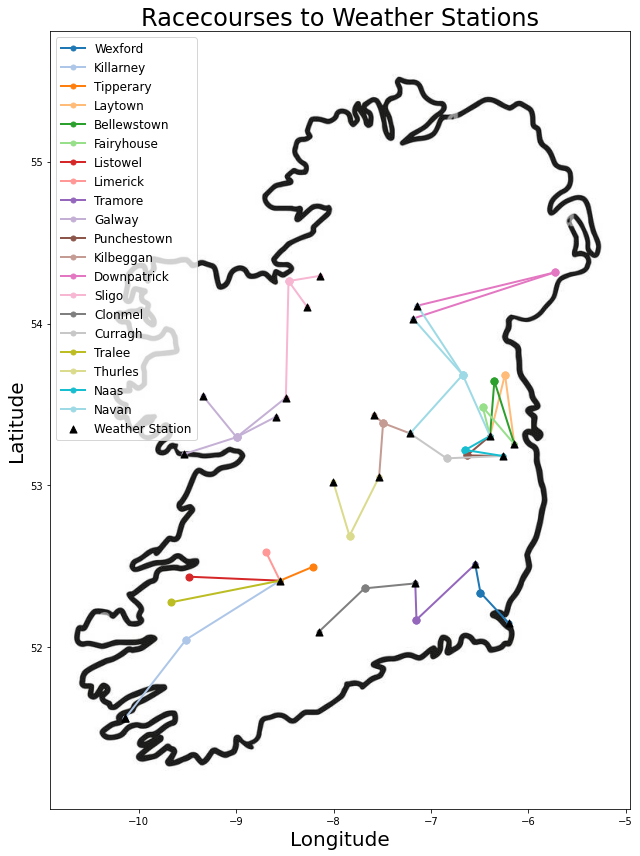

In [27]:
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(1, 1)

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Racecourses to Weather Stations", fontsize=24)

def transform_coords(lat, lng):
    """
    Due to the coordinates of the image.
    """

stations = races_raw[['station name', 'station lng', 'station lat']].groupby('station name').mean().reset_index()
for _, row in stations.iterrows():
    ax1.scatter(row['station lng'], row['station lat'], marker="^", s=50, color='black', zorder=10)
    
ax1.scatter(row['station lng'],
            row['station lat'],
            marker="^",
            s=50,
            color='black',
            zorder=10,
            label='Weather Station')

for idx, course in enumerate(courses):
    fst = True
    color = colors[idx % len(colors)]
    
    for _, row in races_raw[races_raw['course'] == course].iterrows():
        xs = row['lng'], row['station lng']
        ys = row['lat'], row['station lat']
        ax1.plot(xs,
                 ys,
                 color=color,
                 linewidth=2,
                 marker="o",
                 markersize=5,
                 label=course if fst else None,
                 zorder=2)
        
        ax1.scatter(xs[0], ys[0], marker="o", s=50, color=color, zorder=2)
        # ax1.annotate(course, (xs[0], ys[0]))
        
        fst = False
        
ax1.set_xlabel("Longitude", fontsize=20)
ax1.set_ylabel("Latitude", fontsize=20)

xlims = ax1.get_xlim()
ylims = ax1.get_ylim()

plt.imshow(img,
           aspect='auto',
           extent=[
               -10.3634081 - 0.55,
               -5.507829899999998 + 0.55,
               51.424112605 - 0.42,
               54.453235295 + 1.35,
           ],
           zorder=1)

plt.legend(fontsize=12)

plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/map_of_racetracks_to_stations.png")

plt.show()

---